In [64]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import math
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import theano
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import seaborn as sns
import warnings
from pymc3.distributions import distribution
from pymc3.distributions.continuous import Flat, Normal
from decimal import Decimal
from datetime import datetime, timedelta
from collections import OrderedDict

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [100]:
data = np.genfromtxt('toyExample.txt', skip_header=True)
y = np.log(data)
t = np.arange(1,len(y)+1)


Text(0, 0.5, 'y')

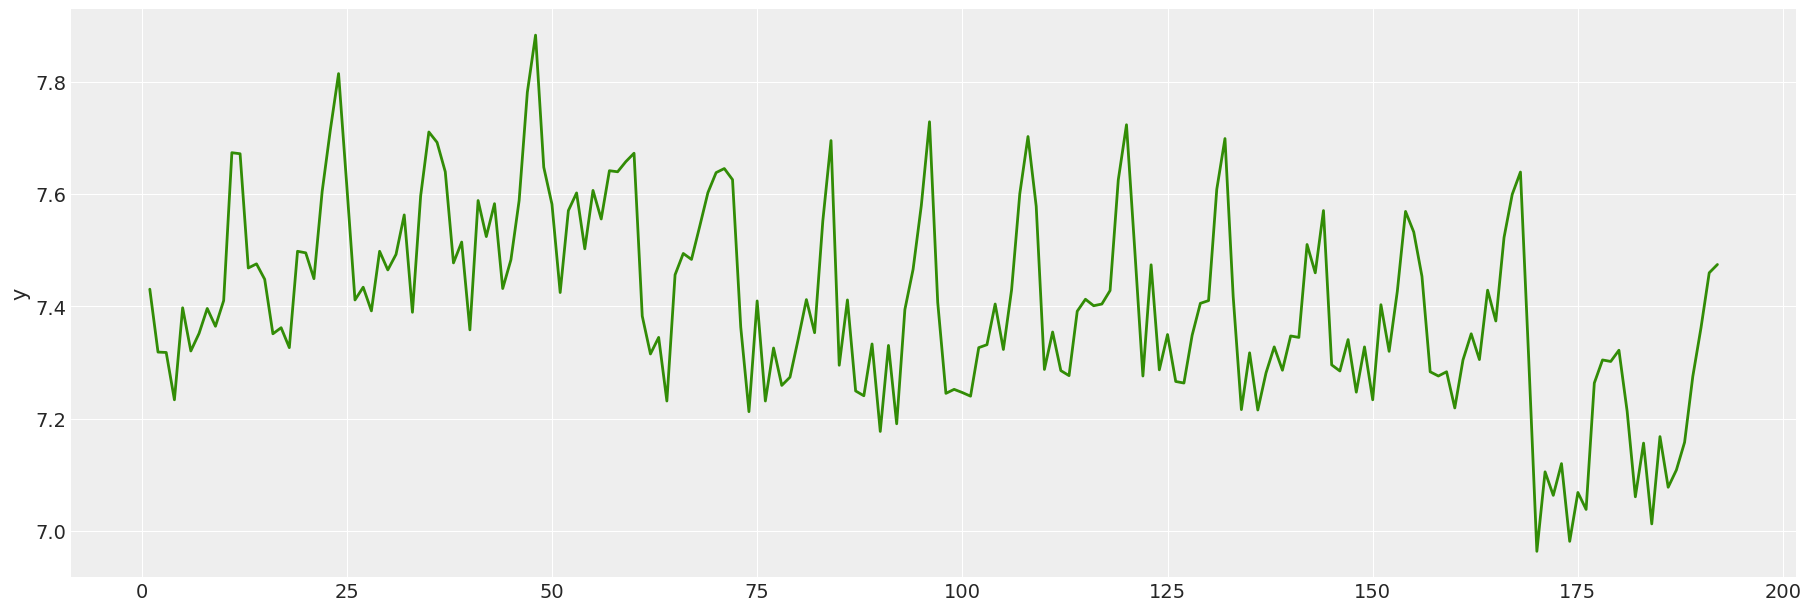

In [101]:
colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(t,
        y, lw=2, c=c3)
ax.set_ylabel("y")

In [102]:
with pm.Model() as m1:
    
    # Priors
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    σ_ξ = pm.HalfNormal('σ_ξ', 1)
    
    # Adaptative prior
    μ = pm.GaussianRandomWalk('μ', 
                              sigma=σ_ξ, 
                              shape=len(y))
    
    # Likelihood
    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ , 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 43600
Interrupted at 43,599 [21%]: Average Loss = 1,407.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ_ξ, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 34 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'σ_ϵ'}>,
        <AxesSubplot:title={'center':'σ_ϵ'}>],
       [<AxesSubplot:title={'center':'σ_ξ'}>,
        <AxesSubplot:title={'center':'σ_ξ'}>]], dtype=object)

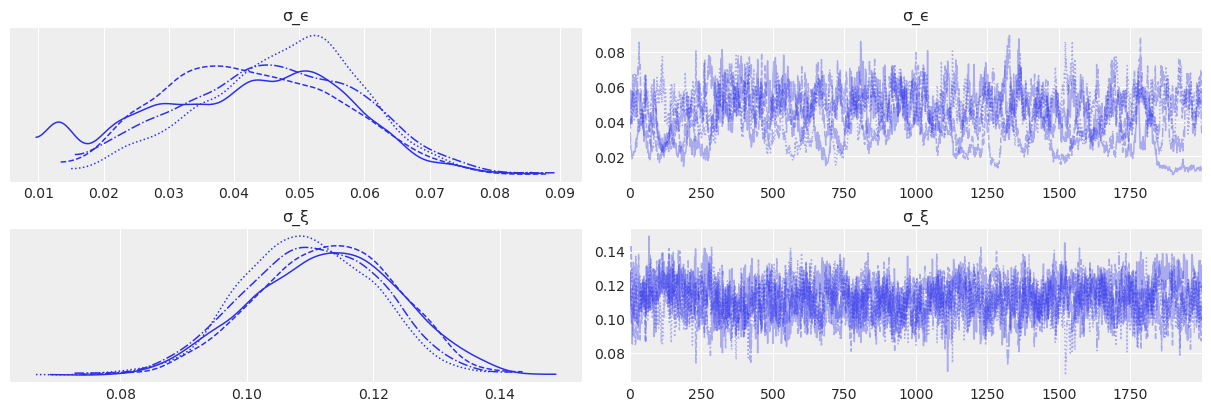

In [68]:
pm.traceplot(trace, var_names=['~μ'])

In [69]:
az.summary(trace, var_names=['~μ'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ_ϵ,0.044,0.014,0.018,0.069,0.001,0.001,96.0,77.0,1.03
σ_ξ,0.111,0.011,0.090,0.131,0.001,0.001,196.0,787.0,1.02


In [70]:
print('σ_ϵ = ' + str(np.mean(trace['σ_ϵ'])))
print('σ_ξ = ' + str(np.mean(trace['σ_ξ'])))

σ_ϵ = 0.04438278
σ_ξ = 0.11121943


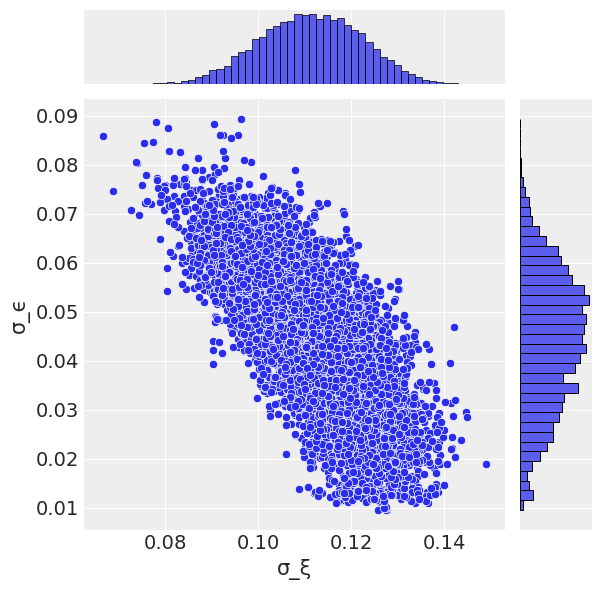

In [71]:
x_ = pd.Series(trace['σ_ξ'], name='σ_ξ')
y_ = pd.Series(trace['σ_ϵ'], name='σ_ϵ')

sns.jointplot(x=x_, y=y_)

In [72]:
with pm.Model() as m2:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    alpha = pm.Uniform('alpha', 0,1)
    μ = pm.GaussianRandomWalk('μ', 
                              sigma=σ_ϵ * (1.0 - alpha), 
                              shape=len(y))
    
    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ * alpha, 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 56400
Interrupted at 56,399 [28%]: Average Loss = 3,506.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.769818538563311, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


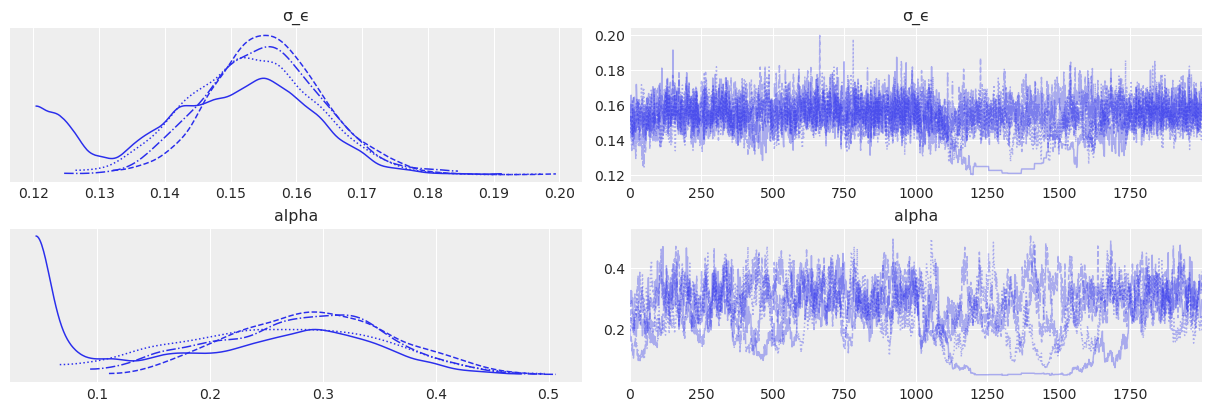

In [73]:
pm.traceplot(trace, var_names=['~μ'])

In [74]:
az.summary(trace, var_names=['~μ'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ_ϵ,0.153,0.011,0.133,0.175,0.002,0.002,28.0,18.0,1.10
alpha,0.261,0.094,0.045,0.392,0.022,0.016,24.0,17.0,1.12


In [76]:
print(np.mean(trace['σ_ϵ'] * trace['alpha']))
print(np.mean(trace['σ_ϵ'] * (1- trace['alpha'])))

0.040628716
0.11237605


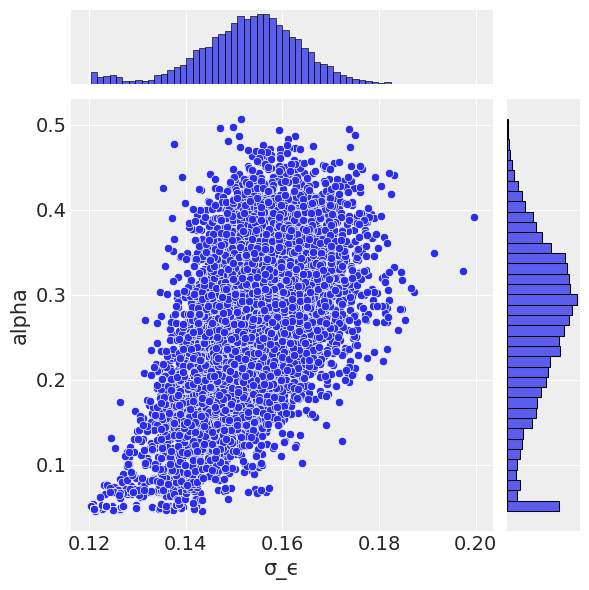

In [77]:
x_ = pd.Series(trace['σ_ϵ'], name='σ_ϵ')
y_ = pd.Series(trace['alpha'], name='alpha')

sns.jointplot(x=x_, y=y_)

In [79]:
class GRW(distribution.Continuous):
    
    def __init__(self, sigma, mu=0, init=Flat.dist(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigma = tt.as_tensor_variable(sigma)
        self.mu = tt.as_tensor_variable(mu)
        self.init = init
        self.mean = tt.as_tensor_variable(0.0)
    
    def logp(self, x):
        x_im1 = x[:-1]
        x_i = x[1:]
        innov_like = Normal.dist(mu=x_im1 + self.mu, sigma=self.sigma).logp(x_i)
        return self.init.logp(x[0]) + tt.sum(innov_like)

In [80]:
with pm.Model() as m4:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    
    alpha = pm.Uniform('alpha', 0,1)
    μ = GRW('μ', sigma=σ_ϵ * (1.0 - alpha), shape=len(y))

    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ * alpha, 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 25200
Interrupted at 25,199 [12%]: Average Loss = 28,370
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.869759687517118, but should be close to 0.95. Try to increase the number of tuning steps.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.831841537983441, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'σ_ϵ'}>,
        <AxesSubplot:title={'center':'σ_ϵ'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

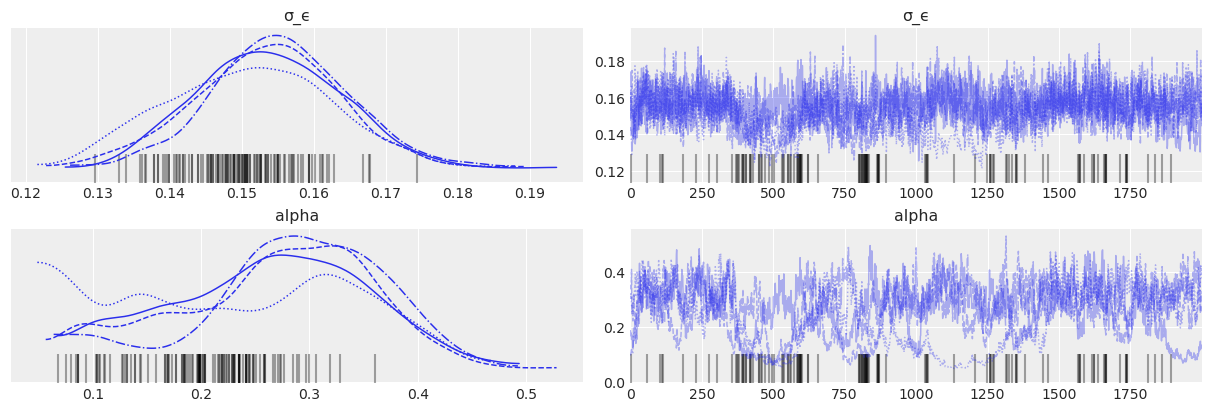

In [81]:
pm.traceplot(trace, var_names=['~μ'])

In [82]:
print(np.mean(trace['σ_ϵ'] * trace['alpha']))
print(np.mean(trace['σ_ϵ'] * (1 - trace['alpha'])))

0.040495113
0.11287503


In [84]:
theano.config.compute_test_value = 'ignore'

def step(s, y, s_previous, α):
    s = α*y + (1-α)*s_previous
    return s

s = tt.vector('s')
y = tt.vector('y')
α = tt.scalar('α')
i = tt.scalar('i')

output, updates = theano.scan(fn=step,
                              sequences=[s, y],
                              non_sequences=[α],
                              outputs_info=[i])

f = theano.function(inputs=[s, y, α, i],
                    outputs=output,
                    updates=updates)

s = np.zeros(9).astype(theano.config.floatX)
y = np.arange(9).astype(theano.config.floatX)
α = 0.7
i = 0

print(f(s, y, α, i)[0:5])

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([iteration_1, 
       iteration_2, 
       iteration_3, 
       iteration_4, 
       iteration_5])

[0.     0.7    1.61   2.583  3.5749]
[0.0, 0.7, 1.6099999999999999, 2.5829999999999997, 3.5749]


In [85]:
s = np.zeros(9)
y = np.arange(0, 9)
α = Decimal('0.7')
i = 0

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([float(iteration_1), 
       float(iteration_2), 
       float(iteration_3), 
       float(iteration_4), 
       float(iteration_5)])

[0.0, 0.7, 1.61, 2.583, 3.5749]


In [87]:
def fn_μ_t(ξ_t, μ_previous):
    μ = μ_previous + ξ_t
    return μ

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)    
    smth_parm = pm.Uniform('alpha', 0,1)
    ξ = pm.Normal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = theano.shared(y[0]*1.)
    
    μ, updates = theano.scan(fn=fn_μ_t, 
                                    sequences = [ξ], 
                                    outputs_info = [μ_1], 
                                    n_steps=len(y))
    level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11300
Interrupted at 11,299 [5%]: Average Loss = 799.45
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ξ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 130 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.900262683813194, but should be close to 0.95. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


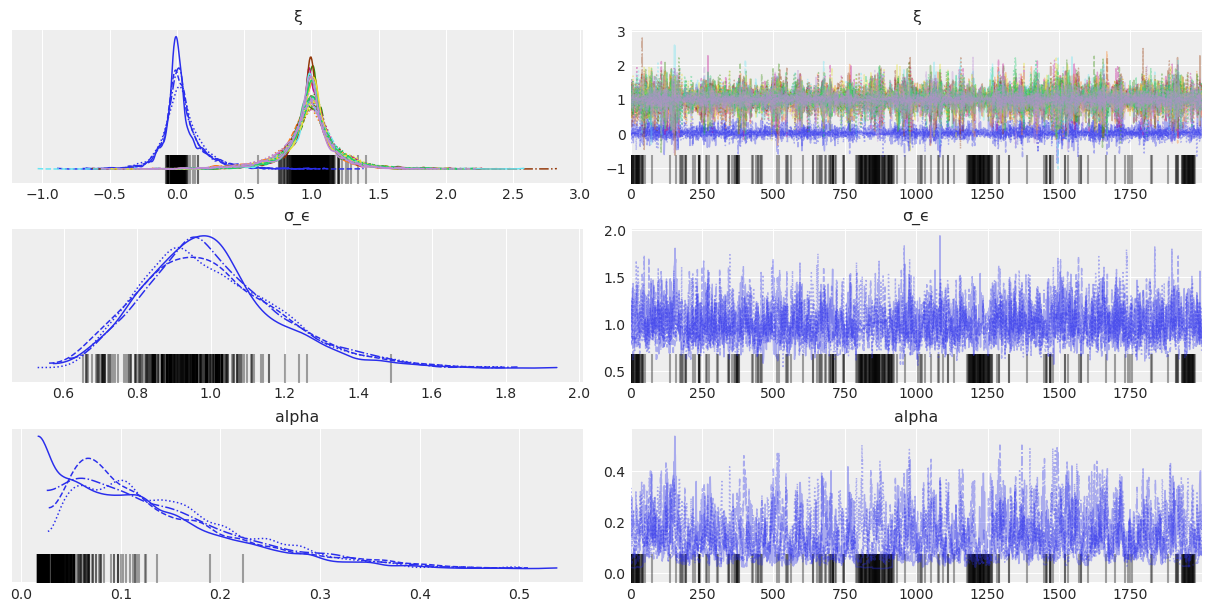

In [89]:
pm.traceplot(trace);

In [90]:
np.round(np.sqrt(model_fit.params),3)

array([0.047, 0.109])

In [91]:
print(np.round(np.mean(trace['σ_ϵ'] * trace['alpha']),3))
print(np.round(np.mean(trace['σ_ϵ'] * (1 - trace['alpha'])),3))

0.141
0.858


In [103]:
dates = ["1969-01-01", "1984-12-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
time = list(OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) for _ in range((end - start).days)).keys())
time

['Jan-69',
 'Feb-69',
 'Mar-69',
 'Apr-69',
 'May-69',
 'Jun-69',
 'Jul-69',
 'Aug-69',
 'Sep-69',
 'Oct-69',
 'Nov-69',
 'Dec-69',
 'Jan-70',
 'Feb-70',
 'Mar-70',
 'Apr-70',
 'May-70',
 'Jun-70',
 'Jul-70',
 'Aug-70',
 'Sep-70',
 'Oct-70',
 'Nov-70',
 'Dec-70',
 'Jan-71',
 'Feb-71',
 'Mar-71',
 'Apr-71',
 'May-71',
 'Jun-71',
 'Jul-71',
 'Aug-71',
 'Sep-71',
 'Oct-71',
 'Nov-71',
 'Dec-71',
 'Jan-72',
 'Feb-72',
 'Mar-72',
 'Apr-72',
 'May-72',
 'Jun-72',
 'Jul-72',
 'Aug-72',
 'Sep-72',
 'Oct-72',
 'Nov-72',
 'Dec-72',
 'Jan-73',
 'Feb-73',
 'Mar-73',
 'Apr-73',
 'May-73',
 'Jun-73',
 'Jul-73',
 'Aug-73',
 'Sep-73',
 'Oct-73',
 'Nov-73',
 'Dec-73',
 'Jan-74',
 'Feb-74',
 'Mar-74',
 'Apr-74',
 'May-74',
 'Jun-74',
 'Jul-74',
 'Aug-74',
 'Sep-74',
 'Oct-74',
 'Nov-74',
 'Dec-74',
 'Jan-75',
 'Feb-75',
 'Mar-75',
 'Apr-75',
 'May-75',
 'Jun-75',
 'Jul-75',
 'Aug-75',
 'Sep-75',
 'Oct-75',
 'Nov-75',
 'Dec-75',
 'Jan-76',
 'Feb-76',
 'Mar-76',
 'Apr-76',
 'May-76',
 'Jun-76',
 'Jul-76',

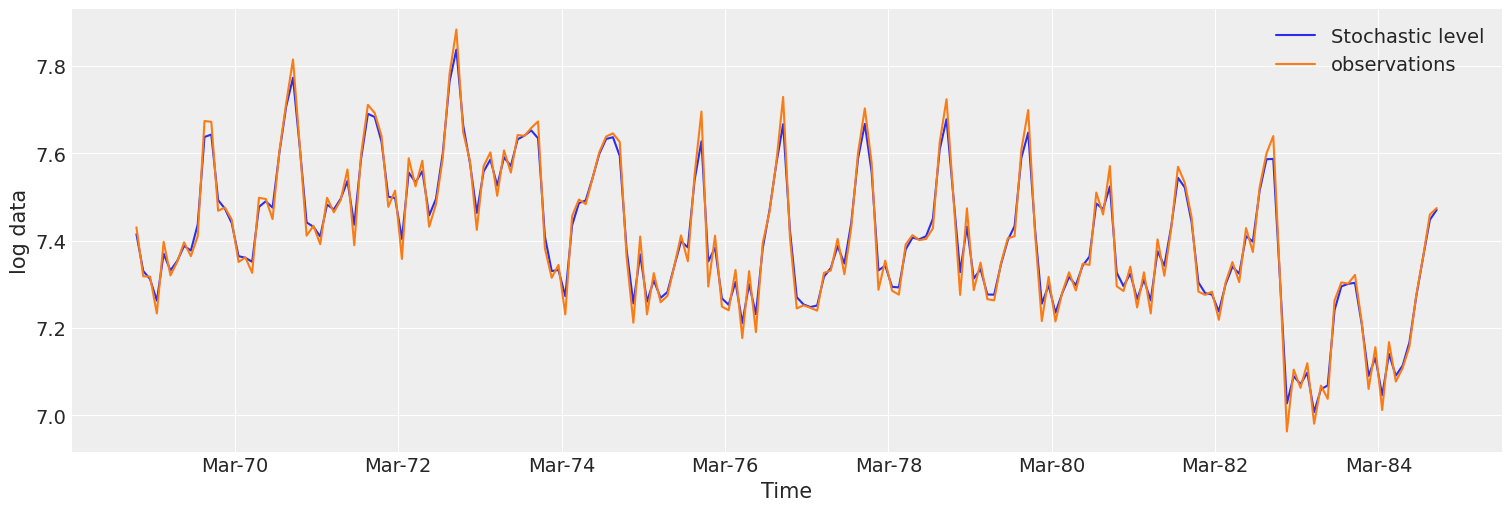

In [104]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(time, model_fit.level['smoothed'], label='Stochastic level')
ax.plot(time, y, label='observations')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
plt.ylabel('log data')
plt.xlabel('Time', rotation=0)
ax.legend()

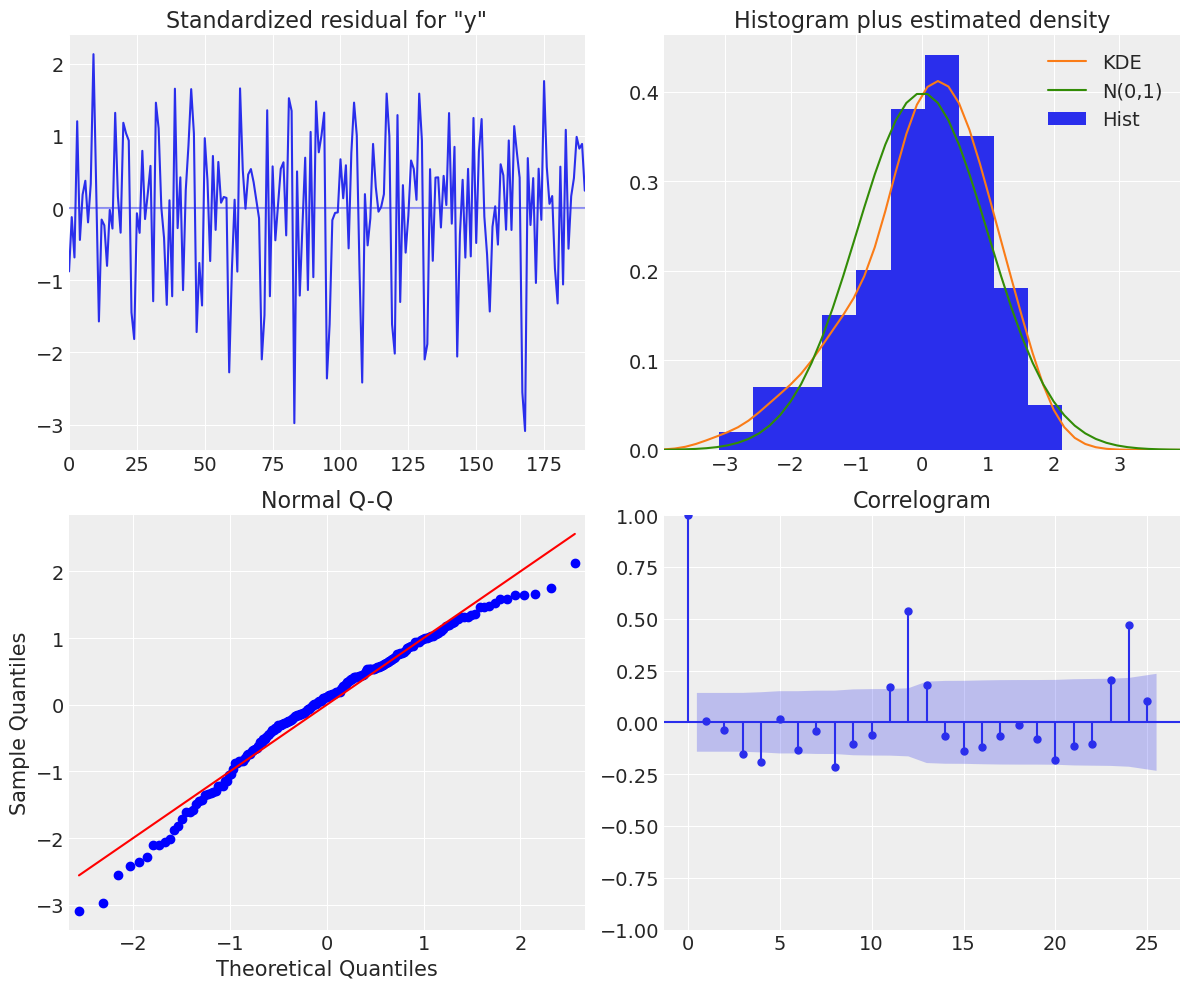

In [105]:
model_fit.plot_diagnostics(lags=25, figsize=(12, 10))
plt.tight_layout()

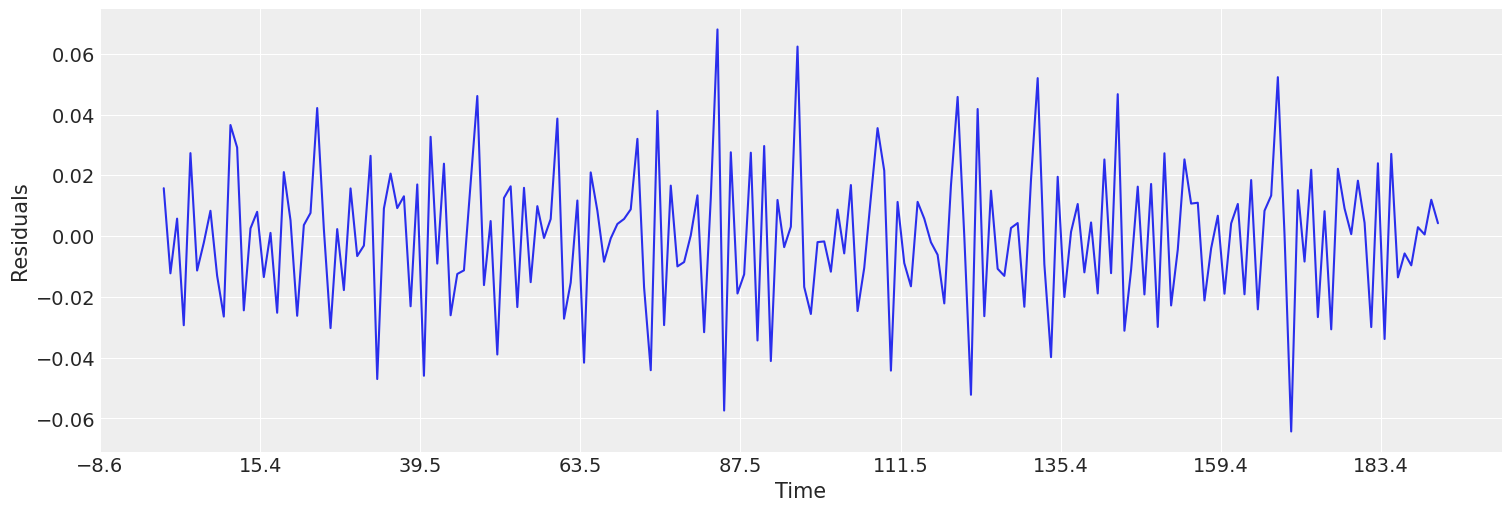

In [106]:
irregular_component = y - model_fit.smoothed_state[0]
_, ax = plt.subplots(figsize=(15,5))
ax.plot(t, irregular_component)
plt.ylabel('Residuals')
plt.xlabel('Time')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))

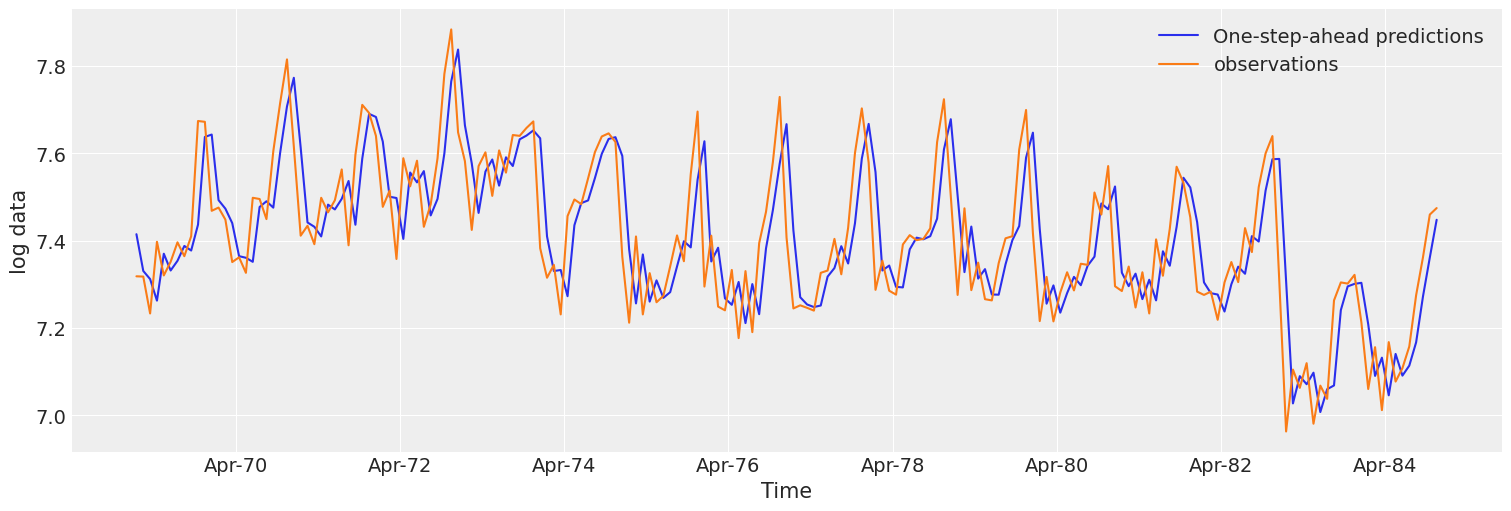

In [107]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(time[1:], model_fit.level['smoothed'][:-1], label='One-step-ahead predictions')
ax.plot(time[1:], y[1:], label='observations')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
plt.ylabel('log data')
plt.xlabel('Time', rotation=0)
ax.legend()

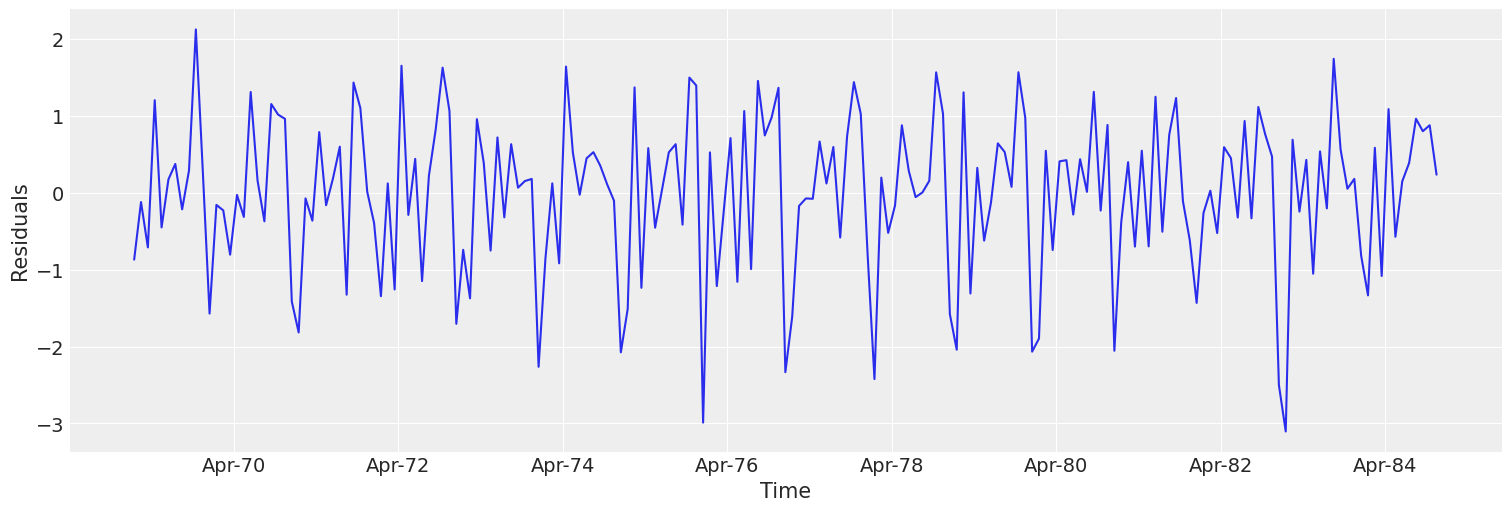

In [108]:
residuals = y[1:] - model_fit.smoothed_state[0][:-1]
residuals = (residuals - np.mean(residuals))/np.std(residuals)
_, ax = plt.subplots(figsize=(15,5))
ax.plot(time[1:], residuals)
plt.ylabel('Residuals')
plt.xlabel('Time')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2));


In [109]:
residuals = model_fit.standardized_forecasts_error[0,:]

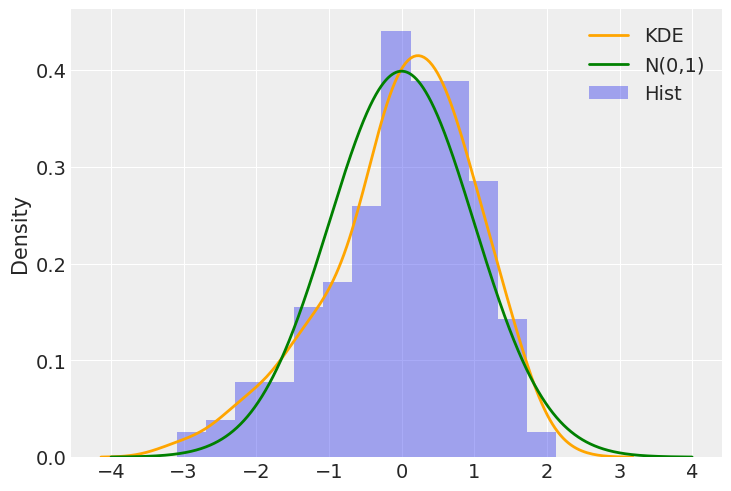

In [110]:
import seaborn as sns
ax = sns.distplot(residuals, 
                  kde_kws={"color": "orange", "lw": 2, "label": "KDE"},
                  hist_kws={"label":"Hist"})
x_ = np.arange(-4, +4, 0.001)                                                   
y_ = stats.norm.pdf(x_)                                    
ax.plot(x_, y_, 'g', lw=2, label='N(0,1)')   
ax.legend();

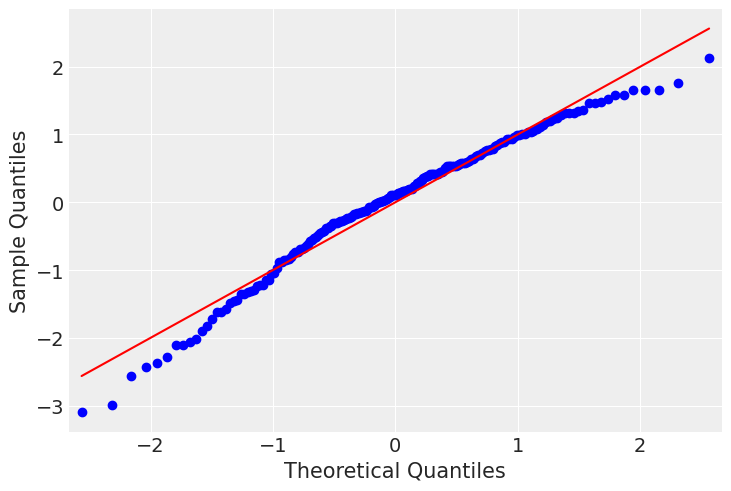

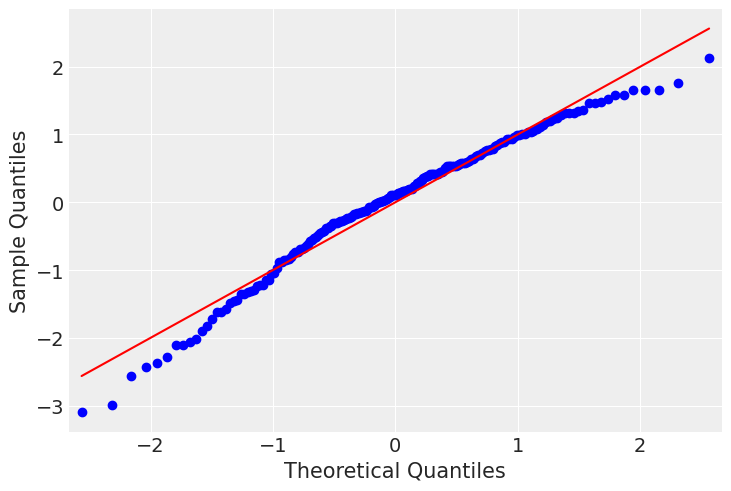

In [111]:
sm.qqplot(residuals, line='s')

In [112]:
resids = np.asarray(residuals)
skew = stats.skew(resids, axis=0)
kurtosis = 3 + stats.kurtosis(resids, axis=0)

n = resids.shape[0]
jb = (n / 6.) * (skew ** 2 + (1 / 4.) * (kurtosis - 3) ** 2)
jb_pv = stats.chi2.sf(jb, 2)

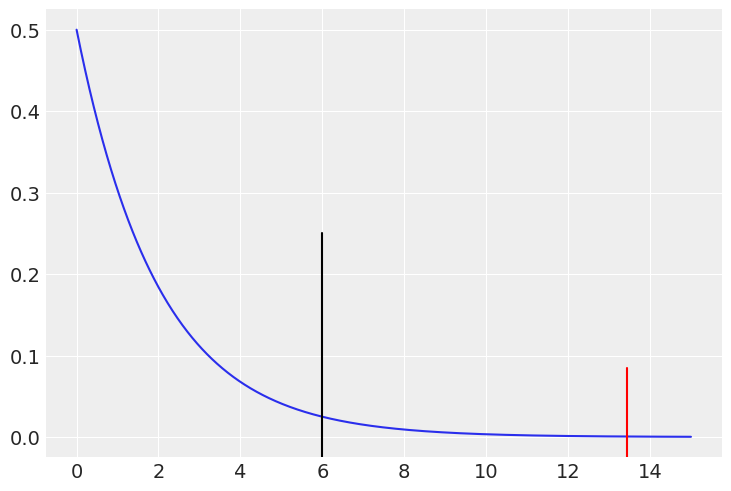

In [113]:
x = np.linspace(0, 15, 1000)
plt.plot(x, stats.chi2.pdf(x, 2))
plt.axvline(stats.chi2.ppf(0.95, 2), ymax=0.5, color='black')
plt.axvline(jb, ymax=0.2, color='red');

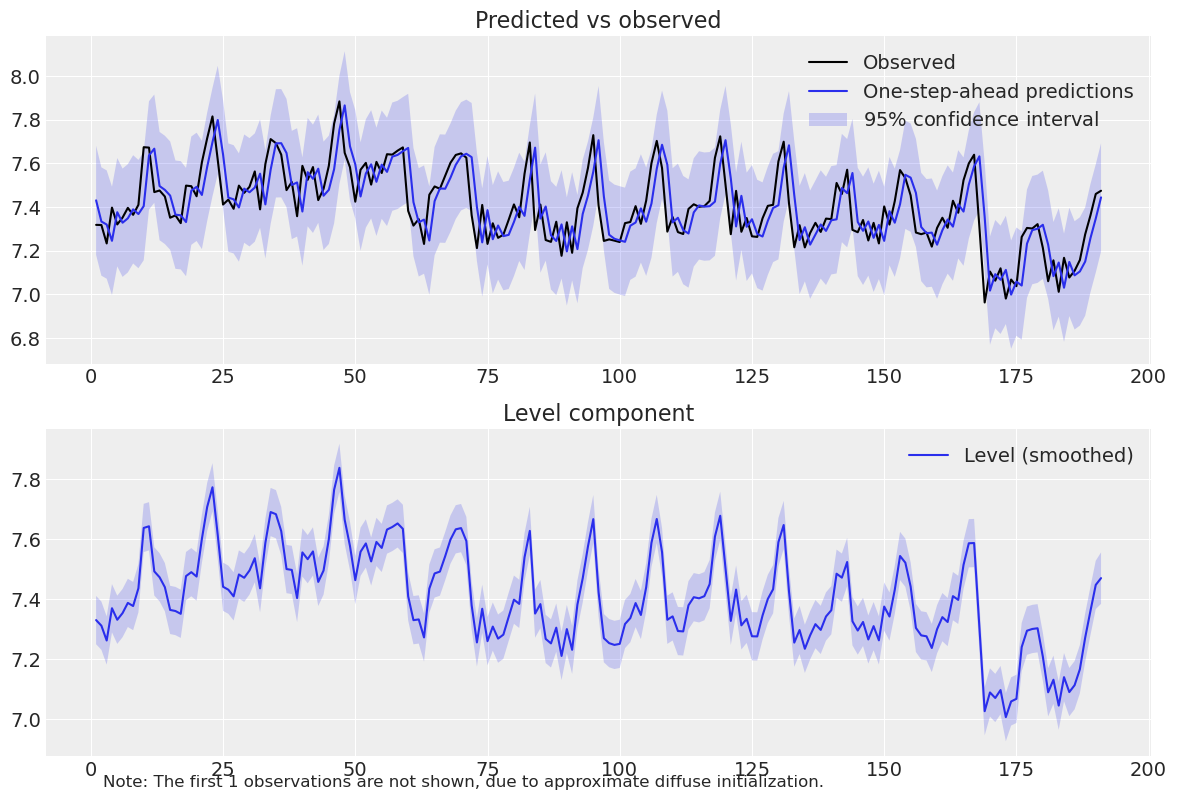

In [114]:
fig = model_fit.plot_components(figsize=(12, 8))
plt.tight_layout()


In [115]:
with m2:
    ppc = pm.sample_posterior_predictive(trace, 200)

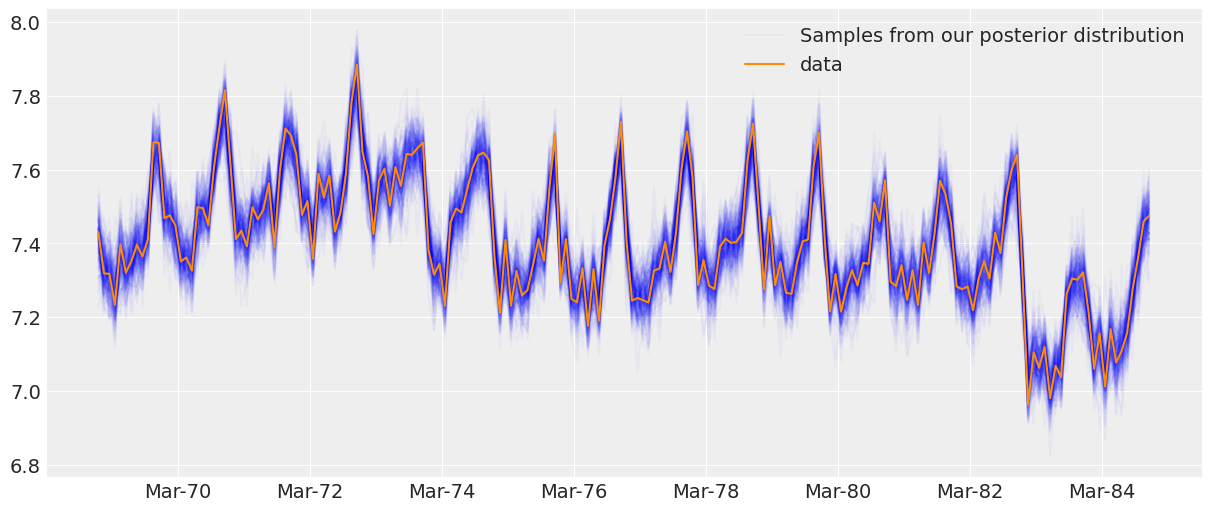

In [116]:
_, ax = plt.subplots(1,1,figsize=(12,5))

ax.plot(time, ppc['level'].T[:,1:], alpha=0.03, color='b', label='_')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))


ax.plot(time,ppc['level'].T[:,1],alpha=0.03, color='b', label='Samples from our posterior distribution')
ax.plot(y, color='darkorange', label='data')
ax.legend();

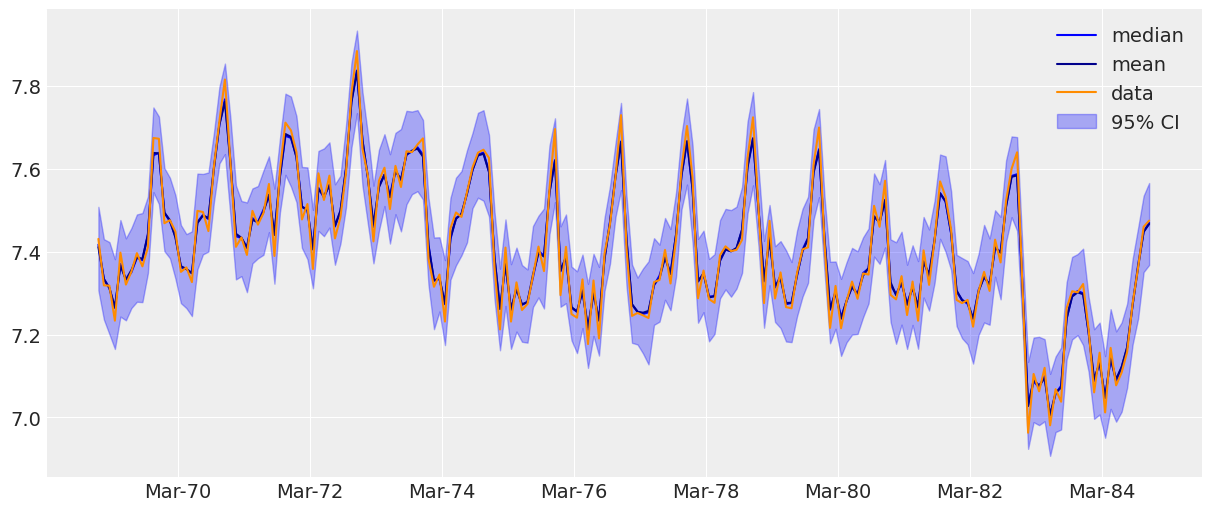

In [118]:
CI = np.percentile(ppc['level'], axis=0, q=[2.5, 50, 97.5])

mean = np.mean(ppc['level'], axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(time,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(y, color='darkorange', label='data')
ax.legend();

Got error No model on context stack. trying to find log_likelihood in translation.


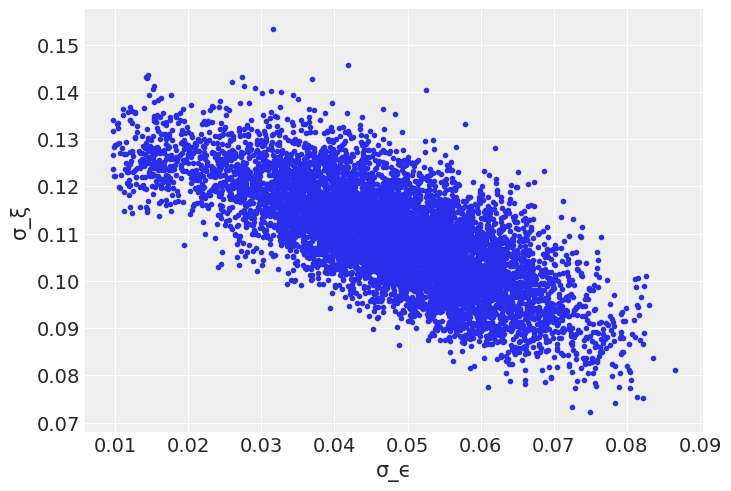

In [119]:
pm.pairplot(trace, var_names=['~μ'])

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'σ_ϵ'}>,
        <AxesSubplot:title={'center':'σ_ϵ'}>],
       [<AxesSubplot:title={'center':'σ_ξ'}>,
        <AxesSubplot:title={'center':'σ_ξ'}>]], dtype=object)

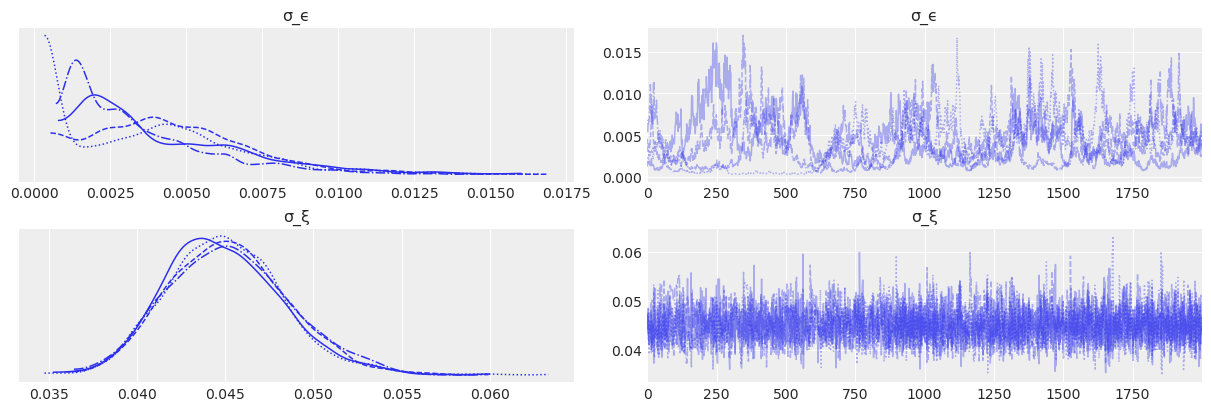

In [38]:
pm.traceplot(trace, var_names=['~μ'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ_ϵ,0.048,0.004,0.041,0.056,0.000,0.000,108.0,546.0,1.04
alpha,0.072,0.046,0.004,0.156,0.008,0.006,25.0,50.0,1.12


0.003592999
0.04479435


σ_ϵ = 0.00404564
σ_ξ = 0.045066886


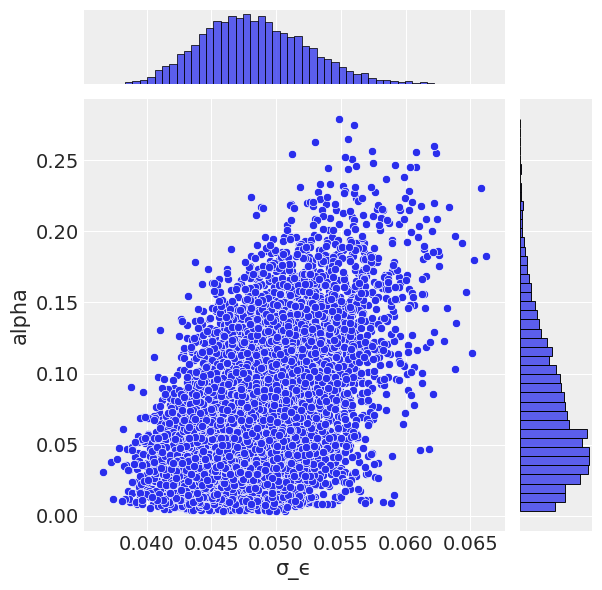

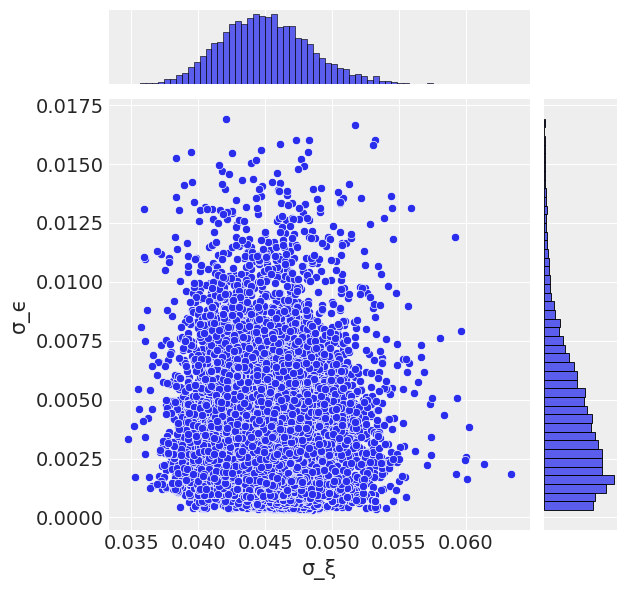